In [1]:
import sys
sys.path.append('../mast3r')
sys.path.append('../dust3r')

In [2]:
import matplotlib.pyplot as plt
import cv2

In [3]:
from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs

import mast3r.utils.path_to_dust3r
from dust3r.inference import inference
from dust3r.utils.image import load_images

Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


/home/user/javeda1/miniconda3/envs/mast3r/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = 'cuda'
schedule = 'cosine'
lr = 0.01
niter = 300

In [5]:
img1 = '/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722747_295433040.png'
img2 = '/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722748_2179484080.png'

In [39]:
img1_path = '/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722747_295433040.png'
img2_path = '/home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722748_2179484080.png'

In [6]:
model_name = "../naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth"
# you can put the path to a local checkpoint in model_name if needed
model = AsymmetricMASt3R.from_pretrained(model_name).to(device)

... loading model from ../naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>


In [7]:
images = load_images([img1, img2], size=512)
output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

# at this stage, you have the raw dust3r predictions
view1, pred1 = output['view1'], output['pred1']
view2, pred2 = output['view2'], output['pred2']

desc1, desc2 = pred1['desc'].squeeze(0).detach(), pred2['desc'].squeeze(0).detach()

# find 2D-2D matches between the two images
matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8,
                                               device=device, dist='dot', block_size=2**13)

>> Loading a list of 2 images
 - adding /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722747_295433040.png with resolution 1920x650 --> 512x160
 - adding /home/nfs/inf6/data/datasets/ThermalDBs/Freiburg/train/seq_00_day/00/fl_rgb/fl_rgb_1570722748_2179484080.png with resolution 1920x650 --> 512x160
 (Found 2 images)


/home/user/javeda1/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/user/javeda1/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/user/javeda1/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [8]:
pred2

{'conf': tensor([[[1.2126, 1.1681, 1.2964,  ..., 2.8813, 2.1177, 1.8073],
          [1.3088, 1.5478, 1.5235,  ..., 3.0352, 3.0231, 2.9579],
          [1.3169, 1.5036, 1.4923,  ..., 2.9056, 2.5742, 2.4959],
          ...,
          [1.6562, 1.6735, 1.7159,  ..., 4.9758, 5.3531, 4.7680],
          [1.4706, 1.5383, 1.5826,  ..., 5.2226, 5.6164, 5.3366],
          [1.3432, 1.5069, 1.6113,  ..., 4.9405, 5.4831, 5.6797]]]),
 'desc': tensor([[[[ 0.3546, -0.1318, -0.2710,  ...,  0.0935,  0.1993, -0.1744],
           [ 0.3045, -0.0332, -0.2240,  ...,  0.1434,  0.1741, -0.1992],
           [ 0.2540, -0.0011, -0.1952,  ...,  0.1436,  0.1682, -0.1934],
           ...,
           [ 0.3264, -0.1500, -0.0736,  ..., -0.3054, -0.3333, -0.0058],
           [ 0.3140, -0.1619, -0.0903,  ..., -0.2929, -0.3417, -0.0310],
           [ 0.3138, -0.1795, -0.0659,  ..., -0.2709, -0.3067, -0.0421]],
 
          [[ 0.3567, -0.0148, -0.2664,  ...,  0.1012,  0.2031, -0.0898],
           [ 0.3565, -0.0041, -0.2379,  

In [9]:
# ignore small border around the edge
H0, W0 = view1['true_shape'][0]
valid_matches_im0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < int(W0) - 3) & (
    matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < int(H0) - 3)

H1, W1 = view2['true_shape'][0]
valid_matches_im1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < int(W1) - 3) & (
    matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < int(H1) - 3)

valid_matches = valid_matches_im0 & valid_matches_im1
matches_im0, matches_im1 = matches_im0[valid_matches], matches_im1[valid_matches]

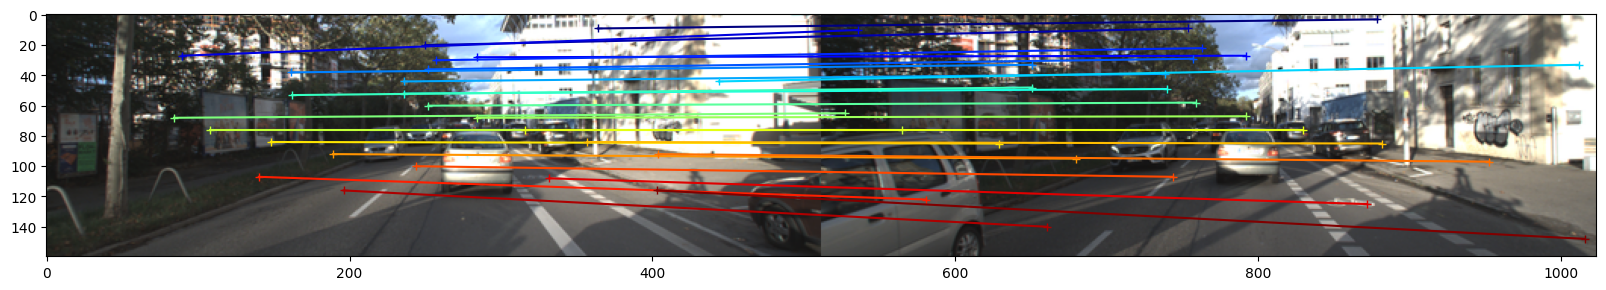

In [10]:
# visualize a few matches
import numpy as np
import torch
import torchvision.transforms.functional
from matplotlib import pyplot as pl

n_viz = 25
num_matches = matches_im0.shape[0]
match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
viz_matches_im0, viz_matches_im1 = matches_im0[match_idx_to_viz], matches_im1[match_idx_to_viz]

image_mean = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)
image_std = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)

viz_imgs = []
for i, view in enumerate([view1, view2]):
    rgb_tensor = view['img'] * image_std + image_mean
    viz_imgs.append(rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())

H0, W0, H1, W1 = *viz_imgs[0].shape[:2], *viz_imgs[1].shape[:2]
img0 = np.pad(viz_imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
img1 = np.pad(viz_imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
img = np.concatenate((img0, img1), axis=1)
pl.figure(figsize=(20, 15))
pl.imshow(img)
cmap = pl.get_cmap('jet')
for i in range(n_viz):
    (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
    pl.plot([x0, x1 + W0], [y0, y1], '-+', color=cmap(i / (n_viz - 1)), scalex=False, scaley=False)
pl.show(block=True)

In [11]:
view1

{'img': tensor([[[[-0.8196, -0.7961, -0.8039,  ..., -0.4510, -0.6157, -0.3020],
           [-0.7882, -0.8039, -0.8118,  ..., -0.6078, -0.5294, -0.3882],
           [-0.7020, -0.7412, -0.8118,  ..., -0.4745, -0.6314, -0.6549],
           ...,
           [-0.7412, -0.7412, -0.7333,  ..., -0.7490, -0.6941, -0.6392],
           [-0.7333, -0.7176, -0.7020,  ..., -0.7804, -0.7569, -0.7098],
           [-0.7333, -0.7020, -0.7020,  ..., -0.7725, -0.7725, -0.7725]],
 
          [[-0.8039, -0.7804, -0.8039,  ..., -0.5608, -0.5765, -0.1059],
           [-0.7804, -0.7882, -0.8039,  ..., -0.6078, -0.5373, -0.3490],
           [-0.6549, -0.7098, -0.7882,  ..., -0.5294, -0.6314, -0.6784],
           ...,
           [-0.7255, -0.7255, -0.7255,  ..., -0.7647, -0.7020, -0.6627],
           [-0.7333, -0.7412, -0.7098,  ..., -0.7882, -0.7569, -0.7255],
           [-0.7490, -0.7255, -0.7020,  ..., -0.7804, -0.7882, -0.7725]],
 
          [[-0.8196, -0.8118, -0.8118,  ..., -0.5843, -0.5686, -0.1765],
      

In [12]:
pred1['pts3d']

tensor([[[[-4.6560, -1.6313,  6.1651],
          [-4.7368, -1.5960,  6.2805],
          [-4.7546, -1.5850,  6.2783],
          ...,
          [ 6.0499, -1.9674,  7.8425],
          [ 6.0839, -1.9082,  7.9113],
          [ 5.7948, -1.9525,  7.8119]],

         [[-4.7806, -1.5154,  6.2324],
          [-4.7632, -1.5468,  6.1565],
          [-4.7062, -1.5447,  6.1388],
          ...,
          [ 6.1351, -1.9407,  7.9027],
          [ 6.0866, -1.9025,  7.8506],
          [ 5.8875, -1.9659,  7.7137]],

         [[-4.7427, -1.5387,  6.1607],
          [-4.7812, -1.5170,  6.2080],
          [-4.7527, -1.4726,  6.1892],
          ...,
          [ 6.0998, -1.8566,  7.9473],
          [ 6.0162, -1.8542,  7.7892],
          [ 5.9794, -1.8607,  7.7241]],

         ...,

         [[-2.3890,  0.7261,  3.0225],
          [-2.3641,  0.7110,  2.9943],
          [-2.3685,  0.7074,  3.0107],
          ...,
          [ 2.0810,  0.6222,  2.6534],
          [ 2.0945,  0.6235,  2.6758],
          [ 2.0764,  0

In [13]:
desc1

tensor([[[ 0.3529, -0.4330, -0.1897,  ..., -0.2138,  0.1927,  0.1227],
         [ 0.0758, -0.4080, -0.1266,  ..., -0.3309,  0.2615,  0.1976],
         [ 0.0567, -0.4192, -0.0960,  ..., -0.3270,  0.2483,  0.2046],
         ...,
         [-0.0024, -0.3875, -0.0818,  ..., -0.3342,  0.2474,  0.2715],
         [ 0.0092, -0.3838, -0.0974,  ..., -0.3299,  0.2335,  0.2619],
         [ 0.1505, -0.3627, -0.0807,  ..., -0.2589,  0.2317,  0.2691]],

        [[ 0.0876, -0.3838, -0.1326,  ..., -0.3151,  0.2118,  0.2012],
         [ 0.0521, -0.3876, -0.1073,  ..., -0.3094,  0.2161,  0.2076],
         [ 0.0499, -0.3984, -0.1011,  ..., -0.3243,  0.2121,  0.2200],
         ...,
         [-0.0046, -0.3694, -0.0785,  ..., -0.3550,  0.2330,  0.2704],
         [-0.0054, -0.3700, -0.0925,  ..., -0.3533,  0.2279,  0.2600],
         [ 0.0563, -0.3565, -0.0883,  ..., -0.3261,  0.2181,  0.2848]],

        [[ 0.0974, -0.3852, -0.1293,  ..., -0.2886,  0.1877,  0.1941],
         [ 0.0412, -0.3838, -0.1068,  ..., -0

In [14]:
F, mask = cv2.findFundamentalMat(matches_im0, matches_im1, method=cv2.FM_RANSAC)

In [15]:
F

array([[ 2.48734025e-06, -1.41704227e-03,  1.15890806e-01],
       [ 1.39790680e-03,  8.73259035e-06, -3.69494732e-01],
       [-1.17938735e-01,  3.66130065e-01,  1.00000000e+00]])

In [16]:
pred2

{'conf': tensor([[[1.2126, 1.1681, 1.2964,  ..., 2.8813, 2.1177, 1.8073],
          [1.3088, 1.5478, 1.5235,  ..., 3.0352, 3.0231, 2.9579],
          [1.3169, 1.5036, 1.4923,  ..., 2.9056, 2.5742, 2.4959],
          ...,
          [1.6562, 1.6735, 1.7159,  ..., 4.9758, 5.3531, 4.7680],
          [1.4706, 1.5383, 1.5826,  ..., 5.2226, 5.6164, 5.3366],
          [1.3432, 1.5069, 1.6113,  ..., 4.9405, 5.4831, 5.6797]]]),
 'desc': tensor([[[[ 0.3546, -0.1318, -0.2710,  ...,  0.0935,  0.1993, -0.1744],
           [ 0.3045, -0.0332, -0.2240,  ...,  0.1434,  0.1741, -0.1992],
           [ 0.2540, -0.0011, -0.1952,  ...,  0.1436,  0.1682, -0.1934],
           ...,
           [ 0.3264, -0.1500, -0.0736,  ..., -0.3054, -0.3333, -0.0058],
           [ 0.3140, -0.1619, -0.0903,  ..., -0.2929, -0.3417, -0.0310],
           [ 0.3138, -0.1795, -0.0659,  ..., -0.2709, -0.3067, -0.0421]],
 
          [[ 0.3567, -0.0148, -0.2664,  ...,  0.1012,  0.2031, -0.0898],
           [ 0.3565, -0.0041, -0.2379,  

In [17]:
import numpy as np
import torch

def estimate_procrustes(X1, X2):
    """
    Estimate the relative pose (R, t) between two sets of corresponding 3D points using Procrustes alignment.
    
    Args:
        X1: (N, 3) PyTorch tensor or NumPy array of 3D points from view 1.
        X2: (N, 3) PyTorch tensor or NumPy array of 3D points from view 2.
    
    Returns:
        R: (3, 3) rotation matrix
        t: (3, 1) translation vector
    """
    assert X1.shape == X2.shape, "Point sets must have the same shape"

    # Convert PyTorch tensors to NumPy if necessary
    if isinstance(X1, torch.Tensor):
        X1 = X1.cpu().detach().numpy()
    if isinstance(X2, torch.Tensor):
        X2 = X2.cpu().detach().numpy()

    # Step 1: Compute centroids
    centroid_X1 = np.mean(X1, axis=0)
    centroid_X2 = np.mean(X2, axis=0)

    # Step 2: Center the points
    X1_centered = X1 - centroid_X1
    X2_centered = X2 - centroid_X2

    # Step 3: Compute the cross-covariance matrix
    H = X1_centered.T @ X2_centered

    # Step 4: Compute SVD of H
    U, S, Vt = np.linalg.svd(H)

    # Step 5: Compute optimal rotation matrix
    R = Vt.T @ U.T

    # Ensure a valid rotation matrix (fix reflection issue)
    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1  # Flip the sign of the last row
        R = Vt.T @ U.T

    # Step 6: Compute translation
    t = centroid_X2 - R @ centroid_X1

    return R, t


In [18]:
# Extract 3D points from MASt3R output
X1 = pred1['pts3d'].reshape(-1, 3)  # Flatten to (N, 3)
X2 = pred2['pts3d_in_other_view'].reshape(-1, 3)

# Remove low-confidence points
conf1, conf2 = pred1['conf'].reshape(-1), pred2['conf'].reshape(-1)
valid = (conf1 > 0.5) & (conf2 > 0.5)  # Filter based on confidence
X1, X2 = X1[valid], X2[valid]

# Estimate relative pose
R, t = estimate_procrustes(X1, X2)

print("Estimated Rotation Matrix R:\n", R)
print("Estimated Translation Vector t:\n", t)

Estimated Rotation Matrix R:
 [[ 0.999644    0.0069854   0.02575091]
 [-0.00713398  0.99995846  0.0056825 ]
 [-0.02571015 -0.00586418  0.99965215]]
Estimated Translation Vector t:
 [-0.11054677 -0.15635985  2.2452812 ]


In [19]:
import numpy as np
import torch

def estimate_camera_intrinsics(X1, matches_im0):
    """
    Estimate the camera intrinsics (f_x, f_y, c_x, c_y) using 3D-2D correspondences.

    Args:
        X1: (N, 3) PyTorch tensor or NumPy array of 3D points.
        matches_im0: (N, 2) array of corresponding 2D pixel locations.

    Returns:
        K: (3, 3) estimated intrinsic matrix.
    """
    assert X1.shape[0] == matches_im0.shape[0], "Mismatch in 3D and 2D points count"

    # Convert PyTorch tensors to NumPy if necessary
    if isinstance(X1, torch.Tensor):
        X1 = X1.cpu().detach().numpy()
    if isinstance(matches_im0, torch.Tensor):
        matches_im0 = matches_im0.cpu().detach().numpy()

    # Extract 3D coordinates
    X, Y, Z = X1[:, 0], X1[:, 1], X1[:, 2]

    # Extract 2D pixel locations
    u, v = matches_im0[:, 0], matches_im0[:, 1]

    # Construct A matrix (ensuring it has 4 unknowns)
    A = np.zeros((2 * len(X), 4))  # We need 2 rows per point
    B = np.zeros((2 * len(X), 1))

    for i in range(len(X)):
        A[2 * i] = [X[i] / Z[i], 0, 1, 0]
        A[2 * i + 1] = [0, Y[i] / Z[i], 0, 1]
        B[2 * i] = u[i]
        B[2 * i + 1] = v[i]

    # Solve for fx, fy, cx, cy using least squares
    solution, _, _, _ = np.linalg.lstsq(A, B, rcond=None)

    # Extract intrinsic parameters
    fx, fy, cx, cy = solution.flatten()

    # Construct intrinsic matrix
    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

    return K


In [20]:
estimate_camera_intrinsics(X1, matches_im0)

AssertionError: Mismatch in 3D and 2D points count

In [21]:
matches_im0.shape

(623, 2)

In [22]:
X1.shape

torch.Size([81920, 3])

In [23]:
depth1 = pred1['pts3d'][..., 2]  # Z-values for Image 1
depth2 = pred2['pts3d_in_other_view'][..., 2]  # Z-values for Image 2

# Convert to NumPy if necessary
if isinstance(depth1, torch.Tensor):
    depth1 = depth1.cpu().detach().numpy()
if isinstance(depth2, torch.Tensor):
    depth2 = depth2.cpu().detach().numpy()

In [24]:
depth1

array([[[6.1650934, 6.2805   , 6.278305 , ..., 7.8425474, 7.9112654,
         7.8119144],
        [6.2324204, 6.156549 , 6.138835 , ..., 7.902656 , 7.8505945,
         7.7136607],
        [6.1607466, 6.208048 , 6.189164 , ..., 7.947328 , 7.78925  ,
         7.724137 ],
        ...,
        [3.0225344, 2.9943454, 3.010696 , ..., 2.6534102, 2.6757677,
         2.653905 ],
        [2.9943898, 2.9760485, 2.9808679, ..., 2.657613 , 2.6429856,
         2.6421604],
        [2.9376512, 2.9241085, 2.9885175, ..., 2.6411855, 2.6037028,
         2.6295135]]], dtype=float32)

In [25]:
depth2

array([[[9.085922 , 8.977465 , 8.720028 , ..., 8.407422 , 8.524846 ,
         8.403654 ],
        [8.900737 , 8.959897 , 8.774301 , ..., 8.3808975, 8.35182  ,
         8.454524 ],
        [8.889432 , 8.8992405, 8.946309 , ..., 8.408475 , 8.322577 ,
         8.377783 ],
        ...,
        [4.787322 , 4.9640527, 4.9649553, ..., 4.9406524, 4.96037  ,
         4.9509263],
        [4.8827744, 4.8715215, 5.02996  , ..., 4.909869 , 4.905089 ,
         4.9443417],
        [4.747009 , 4.8080664, 4.869035 , ..., 4.882052 , 4.9017754,
         4.907191 ]]], dtype=float32)

In [30]:
# Remove batch dimension if it exists
if len(depth1.shape) == 3 and depth1.shape[0] == 1:
    depth1 = depth1.squeeze(0)  # Convert (1, H, W) → (H, W)
if len(depth2.shape) == 3 and depth2.shape[0] == 1:
    depth2 = depth2.squeeze(0)  # Convert (1, H, W) → (H, W)


In [31]:
def normalize_depth(depth):
    """Normalize depth values to range [0,1] for visualization."""
    depth_min, depth_max = np.min(depth), np.max(depth)
    return (depth - depth_min) / (depth_max - depth_min + 1e-6)  # Avoid division by zero

# Normalize depths
depth1_norm = normalize_depth(depth1)
depth2_norm = normalize_depth(depth2)

In [32]:
depth1_norm.shape

(160, 512)

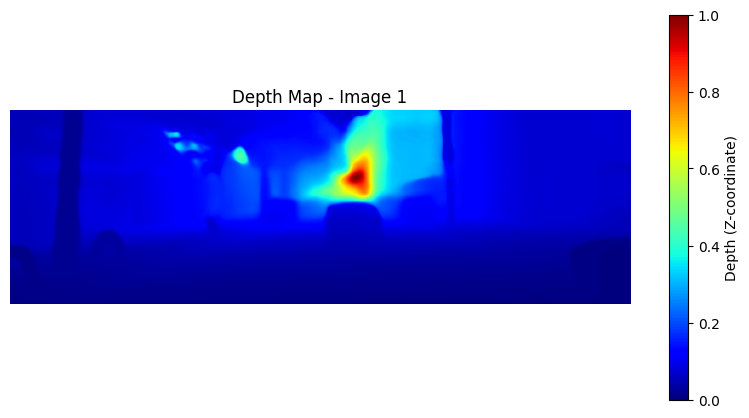

In [34]:
def plot_depth_map(depth, title="Depth Map"):
    plt.figure(figsize=(10, 5))
    plt.imshow(depth, cmap='jet')  # Use 'jet' for colored depth visualization
    plt.colorbar(label="Depth (Z-coordinate)")
    plt.title(title)
    plt.axis("off")
    plt.show()

# Plot the depth maps for both images
plot_depth_map(depth1_norm, title="Depth Map - Image 1")

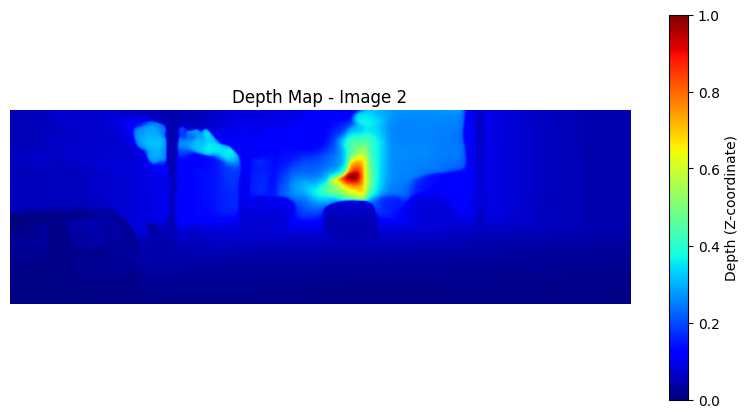

In [35]:
plot_depth_map(depth2_norm, title="Depth Map - Image 2")

In [37]:
!pip3 install opencv-python

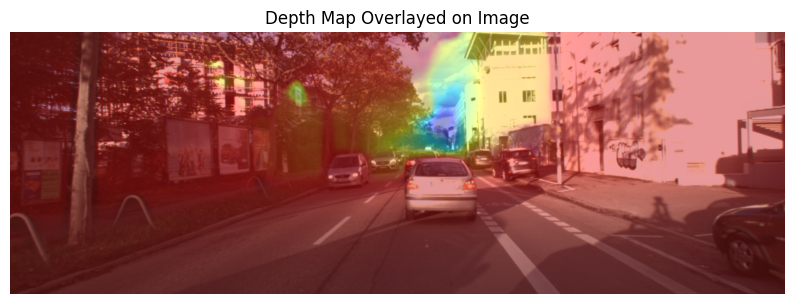

In [40]:
import cv2

# Load the original image
image1 = cv2.imread(img1_path)  # Load image 1
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Resize depth map to match image dimensions
depth1_resized = cv2.resize(depth1_norm, (image1.shape[1], image1.shape[0]))

# Convert depth to color map
depth_colormap = cv2.applyColorMap((depth1_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)

# Blend depth map and image
overlay = cv2.addWeighted(image1, 0.6, depth_colormap, 0.4, 0)

# Show the overlay
plt.figure(figsize=(10, 5))
plt.imshow(overlay)
plt.axis("off")
plt.title("Depth Map Overlayed on Image")
plt.show()

In [41]:
def verify_rotation_matrix(R):
    """Verify if R is a valid rotation matrix."""
    I = np.eye(3)  # Identity matrix
    RtR = R @ R.T  # Should be close to identity
    det_R = np.linalg.det(R)  # Should be close to 1

    print("Rotation Matrix Orthogonality Check (R @ R.T):\n", RtR)
    print("Determinant of R:", det_R)

    is_orthogonal = np.allclose(RtR, I, atol=1e-3)  # Allow small numerical error
    is_det_one = np.isclose(det_R, 1.0, atol=1e-3)

    if is_orthogonal and is_det_one:
        print("✅ The rotation matrix is valid!")
    else:
        print("❌ The rotation matrix is incorrect!")

# Check the obtained rotation matrix
verify_rotation_matrix(R)

Rotation Matrix Orthogonality Check (R @ R.T):
 [[ 1.0000000e+00  1.5037681e-09 -7.5147550e-09]
 [ 1.5037681e-09  1.0000001e+00  8.4403853e-09]
 [-7.5147550e-09  8.4403853e-09  9.9999982e-01]]
Determinant of R: 0.99999994
✅ The rotation matrix is valid!


In [42]:
def skew_symmetric_matrix(t):
    """Convert a translation vector into a skew-symmetric matrix."""
    t_x, t_y, t_z = t.flatten()
    return np.array([
        [  0, -t_z,  t_y],
        [ t_z,   0, -t_x],
        [-t_y,  t_x,   0]
    ])

def verify_essential_matrix(R, t):
    """Check if the computed R and t form a valid Essential Matrix."""
    t_skew = skew_symmetric_matrix(t)
    E = t_skew @ R  # Essential matrix

    # Ensure E has two nonzero singular values and one zero singular value
    U, S, Vt = np.linalg.svd(E)

    print("Singular values of the Essential Matrix:", S)
    if np.isclose(S[0], S[1], atol=1e-3) and np.isclose(S[2], 0, atol=1e-3):
        print("✅ The essential matrix is valid!")
    else:
        print("❌ The essential matrix is incorrect!")

# Verify Essential Matrix
verify_essential_matrix(R, t)

Singular values of the Essential Matrix: [2.25343232e+00 2.25343221e+00 2.62600113e-18]
✅ The essential matrix is valid!


In [43]:
def reproject_and_verify(X1, K, R, t, matches_im1):
    """Reproject 3D points and compare with original 2D matches."""
    X2_transformed = (R @ X1.T).T + t.T  # Apply transformation

    # Project to 2D
    X2_homogeneous = np.hstack([X2_transformed, np.ones((X2_transformed.shape[0], 1))])
    projected_2D = (K @ X2_homogeneous.T).T  # Multiply by K
    projected_2D = projected_2D[:, :2] / projected_2D[:, 2:]  # Convert from homogeneous coordinates

    # Compute error
    reprojection_error = np.linalg.norm(projected_2D - matches_im1, axis=1).mean()

    print(f"Reprojection error: {reprojection_error:.3f} pixels")

    if reprojection_error < 5:  # Typically <5 pixels for good results
        print("✅ The estimated (R, t) are consistent with the 3D-to-2D matches!")
    else:
        print("❌ Large reprojection error! The estimated (R, t) might be incorrect.")

# Run reprojection check
reproject_and_verify(X1, K, R, t, matches_im1)

NameError: name 'K' is not defined

In [45]:
X1 = pred1['pts3d'].reshape(-1, 3)  # (N, 3) 3D points
X1

tensor([[-4.6560, -1.6313,  6.1651],
        [-4.7368, -1.5960,  6.2805],
        [-4.7546, -1.5850,  6.2783],
        ...,
        [ 2.0520,  0.6366,  2.6412],
        [ 2.0440,  0.6550,  2.6037],
        [ 2.0481,  0.6604,  2.6295]])

In [46]:
matches_im0 = matches_im0.reshape(-1, 2)  # (N, 2) pixel coordinates
matches_im0

array([[364,   9],
       [293,  12],
       [300,  12],
       ...,
       [388, 116],
       [396, 116],
       [403, 116]])

In [47]:
import numpy as np
import torch

def estimate_camera_intrinsics(X1, matches_im0):
    """
    Estimate the camera intrinsics (f_x, f_y, c_x, c_y) using 3D-2D correspondences.

    Args:
        X1: (N, 3) array of 3D points.
        matches_im0: (N, 2) array of corresponding 2D pixel locations.

    Returns:
        K: (3, 3) estimated intrinsic matrix.
    """
    assert X1.shape[0] == matches_im0.shape[0], "Mismatch in 3D and 2D points count"

    # Convert PyTorch tensors to NumPy if necessary
    if isinstance(X1, torch.Tensor):
        X1 = X1.cpu().detach().numpy()
    if isinstance(matches_im0, torch.Tensor):
        matches_im0 = matches_im0.cpu().detach().numpy()

    # Extract 3D coordinates
    X, Y, Z = X1[:, 0], X1[:, 1], X1[:, 2]

    # Extract 2D pixel coordinates
    u, v = matches_im0[:, 0], matches_im0[:, 1]

    # Construct A matrix (ensuring 4 unknowns: f_x, f_y, c_x, c_y)
    A = np.zeros((2 * len(X), 4))  # We need 2 rows per point
    B = np.zeros((2 * len(X), 1))

    for i in range(len(X)):
        A[2 * i] = [X[i] / Z[i], 0, 1, 0]
        A[2 * i + 1] = [0, Y[i] / Z[i], 0, 1]
        B[2 * i] = u[i]
        B[2 * i + 1] = v[i]

    # Solve for fx, fy, cx, cy using least squares
    solution, _, _, _ = np.linalg.lstsq(A, B, rcond=None)

    # Extract intrinsic parameters
    fx, fy, cx, cy = solution.flatten()

    # Construct intrinsic matrix
    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

    return K


In [48]:
# Ensure data is NumPy
if isinstance(X1, torch.Tensor):
    X1 = X1.cpu().detach().numpy()
if isinstance(matches_im0, torch.Tensor):
    matches_im0 = matches_im0.cpu().detach().numpy()

# Match the number of 3D and 2D points
min_count = min(X1.shape[0], matches_im0.shape[0])
X1_aligned = X1[:min_count]
matches_im0_aligned = matches_im0[:min_count]

# Estimate camera intrinsics
K_estimated = estimate_camera_intrinsics(X1_aligned, matches_im0_aligned)

print("Estimated Camera Intrinsic Matrix:")
print(K_estimated)

Estimated Camera Intrinsic Matrix:
[[-10.34094752   0.         260.62074722]
 [  0.         461.06271493 175.76916691]
 [  0.           0.           1.        ]]


In [49]:
X1.shape[0], matches_im0.shape[0]

(81920, 623)

In [74]:
def reproject_and_verify(X1, K, matches_im0):
    """Reproject 3D points using estimated K and check error."""
    
    # Extract (X, Y, Z) and normalize by depth (Z)
    X, Y, Z = X1[:, 0], X1[:, 1], X1[:, 2]
    X_norm = X / Z
    Y_norm = Y / Z

    # Construct (N,3) array for projection
    X1_homogeneous = np.stack([X_norm, Y_norm, np.ones_like(Z)], axis=-1)  # (N, 3)

    # Multiply with intrinsic matrix K
    projected_2D = (K @ X1_homogeneous.T).T  # Shape: (N, 3)

    # Convert to 2D coordinates (divide by last coordinate)
    projected_2D = projected_2D[:, :2]  # (N, 2)

    # Compute reprojection error
    error = np.linalg.norm(projected_2D - matches_im0, axis=1).mean()
    print(f"Reprojection Error: {error:.3f} pixels")

# Run reprojection check
reproject_and_verify(X1_aligned, K_estimated, matches_im0_aligned)

Reprojection Error: 172.966 pixels


In [52]:
import matplotlib.pyplot as plt

def plot_reprojection_errors(matches_im0, projected_2D):
    """Plot original vs. reprojected 2D points to visualize errors."""
    plt.figure(figsize=(10, 6))
    plt.scatter(matches_im0[:, 0], matches_im0[:, 1], color='blue', label='Original 2D Points', s=5)
    plt.scatter(projected_2D[:, 0], projected_2D[:, 1], color='red', label='Reprojected 2D Points', s=5)
    plt.legend()
    plt.xlabel("Image Width (u)")
    plt.ylabel("Image Height (v)")
    plt.title("Original vs. Reprojected 2D Points")
    plt.show()

plot_reprojection_errors(matches_im0_aligned, projected_2D)


NameError: name 'projected_2D' is not defined

In [57]:
valid_mask =depth1 > 0  # Remove invalid depth values (negative or zero depth)
X1_filtered = X1[valid_mask]
matches_im0_filtered = matches_im0[valid_mask]

IndexError: boolean index did not match indexed array along axis 0; size of axis is 81920 but size of corresponding boolean axis is 160

In [58]:
valid_mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [59]:
import cv2

def estimate_K_with_ransac(X1, matches_im0):
    """Estimate intrinsics using RANSAC to remove outliers."""
    X, Y, Z = X1[:, 0], X1[:, 1], X1[:, 2]
    u, v = matches_im0[:, 0], matches_im0[:, 1]

    # Construct A matrix
    A = np.zeros((2 * len(X), 4))
    B = np.zeros((2 * len(X), 1))

    for i in range(len(X)):
        A[2 * i] = [X[i] / Z[i], 0, 1, 0]
        A[2 * i + 1] = [0, Y[i] / Z[i], 0, 1]
        B[2 * i] = u[i]
        B[2 * i + 1] = v[i]

    # Use RANSAC to find best inliers
    _, inliers = cv2.findFundamentalMat(matches_im0, matches_im0, cv2.FM_RANSAC)
    inliers = inliers.ravel().astype(bool)

    # Solve least squares only on inliers
    A_inliers = A[inliers]
    B_inliers = B[inliers]

    solution, _, _, _ = np.linalg.lstsq(A_inliers, B_inliers, rcond=None)
    fx, fy, cx, cy = solution.flatten()

    return np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

# Run RANSAC-based estimation
K_refined = estimate_K_with_ransac(X1_aligned, matches_im0_aligned)

print("Refined Camera Intrinsic Matrix:")
print(K_refined)


IndexError: boolean index did not match indexed array along axis 0; size of axis is 1246 but size of corresponding boolean axis is 623

In [69]:
from scipy.spatial import cKDTree

# Create pixel grid for MASt3R's 3D pointmap (same size as the image)
H, W = pred1['pts3d'].shape[:2]
u_grid, v_grid = np.meshgrid(np.arange(W), np.arange(H))  # (H, W)

# Flatten grids and 3D points
pixel_coords = np.vstack([u_grid.ravel(), v_grid.ravel()]).T  # (N, 2)
X1_flattened = X1.reshape(-1, 3)  # Flatten 3D points to (N, 3)

# Build KD-Tree with the 2D pixel coordinates of the 3D points
tree = cKDTree(pixel_coords)

# Find nearest 3D point for each 2D match
_, indices = tree.query(matches_im0, k=1)  # Find closest 3D points

# Select only the corresponding 3D points
object_points = X1_flattened[indices]
image_points = matches_im0  # Keep the original 2D points

In [65]:
# Extract 3D coordinates (X, Y, Z)
X, Y, Z = X1[:, 0], X1[:, 1], X1[:, 2]

# Extract 2D pixel coordinates (u, v)
u, v = matches_im0[:, 0], matches_im0[:, 1]

# Stack them as arrays
object_points = np.vstack((X, Y, Z)).T  # Shape (N, 3)
image_points = np.vstack((u, v)).T      # Shape (N, 2)

In [71]:
def estimate_camera_intrinsics_2d_3d(object_points, image_points):
    """
    Estimate camera intrinsic matrix K using 2D-3D correspondences.

    Args:
        object_points: (N, 3) array of 3D points.
        image_points: (N, 2) array of corresponding 2D points.

    Returns:
        K: (3, 3) estimated intrinsic matrix.
    """
    assert object_points.shape[0] == image_points.shape[0], "Mismatch in 3D-2D points count"

    # Image size (width, height)
    image_size = (int(image_points[:, 0].max()), int(image_points[:, 1].max()))

    # Run camera calibration without intrinsic guess
    success, K, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
        [object_points.astype(np.float32)],  # Convert to float32
        [image_points.astype(np.float32)],
        image_size, None, None  # Remove intrinsic guess flag
    )

    if not success:
        print("❌ Camera calibration failed!")
        return None

    return K


# Estimate K
K_estimated = estimate_camera_intrinsics_2d_3d(object_points, image_points)

print("Estimated Camera Intrinsic Matrix:")
print(K_estimated)


error: OpenCV(4.11.0) /io/opencv/modules/calib3d/src/calibration.cpp:321: error: (-5:Bad argument) For non-planar calibration rigs the initial intrinsic matrix must be specified in function 'calibrateCameraInternal'


In [68]:
object_points.shape, image_points.shape

((81920, 3), (623, 2))

In [72]:
def estimate_camera_intrinsics_2d_3d(object_points, image_points):
    """
    Estimate camera intrinsic matrix K using 2D-3D correspondences.

    Args:
        object_points: (N, 3) array of 3D points.
        image_points: (N, 2) array of corresponding 2D points.

    Returns:
        K: (3, 3) estimated intrinsic matrix.
    """
    assert object_points.shape[0] == image_points.shape[0], "Mismatch in 3D-2D points count"

    # Define image size (width, height)
    image_width = int(image_points[:, 0].max())
    image_height = int(image_points[:, 1].max())
    image_size = (image_width, image_height)

    # Provide an initial guess for the camera intrinsic matrix
    f_guess = max(image_width, image_height)  # Assume fx, fy ~ image size
    K_0 = np.array([[f_guess, 0, image_width / 2],
                    [0, f_guess, image_height / 2],
                    [0, 0, 1]], dtype=np.float32)

    # Run camera calibration with intrinsic guess
    success, K, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
        [object_points.astype(np.float32)],  # Convert to float32
        [image_points.astype(np.float32)],
        image_size, K_0, None,  # Use initial guess
        flags=cv2.CALIB_USE_INTRINSIC_GUESS  # Tell OpenCV to refine K
    )

    if not success:
        print("❌ Camera calibration failed!")
        return None

    return K

In [73]:
# Estimate K
K_estimated = estimate_camera_intrinsics_2d_3d(object_points, image_points)

print("Estimated Camera Intrinsic Matrix:")
print(K_estimated)

Estimated Camera Intrinsic Matrix:
[[152.44862979   0.         124.45119276]
 [  0.         -10.76290406  63.94016804]
 [  0.           0.           1.        ]]


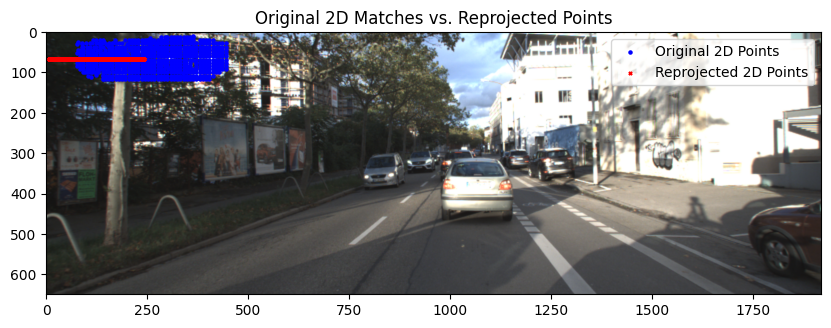

In [75]:
import matplotlib.pyplot as plt

def visualize_reprojection(X1, K, matches_im0, image):
    """
    Visualize reprojected 3D points vs. original 2D keypoints.

    Args:
        X1: (N, 3) 3D world points.
        K: (3, 3) Estimated camera intrinsic matrix.
        matches_im0: (N, 2) Original 2D feature matches.
        image: Original image for visualization.
    """
    # Extract (X, Y, Z)
    X, Y, Z = X1[:, 0], X1[:, 1], X1[:, 2]

    # Project 3D points to 2D using estimated K
    X_homogeneous = np.vstack([X, Y, Z, np.ones_like(Z)])  # (4, N)
    projected_2D = (K @ X_homogeneous[:3, :]).T  # Multiply by K
    projected_2D = projected_2D[:, :2] / projected_2D[:, 2:]  # Convert to (N, 2)

    # Plot on image
    plt.figure(figsize=(10, 6))
    plt.imshow(image, cmap="gray")
    plt.scatter(matches_im0[:, 0], matches_im0[:, 1], color='blue', marker='o', s=5, label='Original 2D Points')
    plt.scatter(projected_2D[:, 0], projected_2D[:, 1], color='red', marker='x', s=5, label='Reprojected 2D Points')
    plt.legend()
    plt.title("Original 2D Matches vs. Reprojected Points")
    plt.show()

# Run visualization
visualize_reprojection(X1_aligned, K_estimated, matches_im0_aligned, image1)


In [78]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_reprojection_Rt(X1, R, t, K, matches_im1, image2):
    """
    Visualize reprojected 3D points after applying (R, t) and compare with original 2D matches.

    Args:
        X1: (N, 3) 3D world points in Camera 1.
        R: (3, 3) Rotation matrix.
        t: (3, 1) Translation vector.
        K: (3, 3) Camera intrinsic matrix.
        matches_im1: (N, 2) Original 2D feature matches in Image 2.
        image2: Camera 2 image for visualization.
    """
    # Transform 3D points from Camera 1 to Camera 2
    X2_transformed = (R @ X1.T).T + t.T  # Shape (N, 3)

    # Convert to homogeneous coordinates for projection
    X2_homogeneous = np.hstack([X2_transformed, np.ones((X2_transformed.shape[0], 1))])

    # Project onto Image 2
    projected_2D = (K @ X2_homogeneous.T).T
    projected_2D = projected_2D[:, :2] / projected_2D[:, 2:]  # Convert to 2D coordinates

    # Plot on Image 2
    plt.figure(figsize=(10, 6))
    plt.imshow(image2, cmap="gray")
    plt.scatter(matches_im1[:, 0], matches_im1[:, 1], color='blue', marker='o', s=5, label='Original 2D Matches')
    plt.scatter(projected_2D[:, 0], projected_2D[:, 1], color='red', marker='x', s=5, label='Transformed 2D Points')
    plt.legend()
    plt.title("Reprojected 3D Points vs. Original Matches")
    plt.show()

# Run visualization
visualize_reprojection_Rt(X1_aligned, R, t, K_estimated, matches_im1, img2)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 3)

In [79]:
R

array([[ 0.999644  ,  0.0069854 ,  0.02575091],
       [-0.00713398,  0.99995846,  0.0056825 ],
       [-0.02571015, -0.00586418,  0.99965215]], dtype=float32)

In [80]:
t

array([-0.11054677, -0.15635985,  2.2452812 ], dtype=float32)

In [82]:
import numpy as np

# Left Camera Intrinsics
K_left = np.array([
    [510.10, 0, 315.85],
    [0, 510.37, 253.19],
    [0, 0, 1]
])

# Right Camera Intrinsics
K_right = np.array([
    [510.42, 0, 300.52],
    [0, 510.49, 244.41],
    [0, 0, 1]
])

In [84]:
dist_left = np.array([-0.4316, 0.1851, 0.00097, 0.00087])
dist_right = np.array([-0.4347, 0.1959, 0.00039, 0.00049])

In [89]:
import cv2

def undistort_image(image, K, dist_coeffs):
    """
    Undistorts an image using given camera intrinsics and distortion coefficients.
    """
    h, w = image.shape[:2]
    new_K, roi = cv2.getOptimalNewCameraMatrix(K, dist_coeffs, (w, h), 1, (w, h))
    undistorted_image = cv2.undistort(image, K, dist_coeffs, None, new_K)
    return undistorted_image

# Example usage (assuming you have loaded left and right images)
left_undistorted = undistort_image(img1, K_left, dist_left)
right_undistorted = undistort_image(img2, K_right, dist_right)

In [88]:
img2 = cv2.imread(img2)